In [10]:
# ============================================================================
# RESIDUAL STREAM ANALYSIS - HTSAT HEADS SPECIALIZATION
# ============================================================================

import torch
import numpy as np
from tqdm.notebook import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# ML & Analysis
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.manifold import TSNE
from skdim.id import TwoNN

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import pandas as pd

# Custom imports
from CLAPWrapper import CLAPWrapper
from datasets.esc50 import ESC50

# Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print(f"✅ Device: {device}")
print(f"✅ All imports successful")

✅ Device: cpu
✅ All imports successful


In [11]:
# ============================================================================
# LOAD DATASET & MODEL
# ============================================================================

# Dataset
root_path = "./data"
dataset = ESC50(root=root_path, download=True)

print(f"📊 Dataset: {len(dataset)} samples, {len(dataset.classes)} classes")
print(f"   Classes: {dataset.classes[:5]}... (+{len(dataset.classes)-5} more)")

# CLAP Model
wrapper = CLAPWrapper(version='2023', use_cuda=torch.cuda.is_available())
clap_model = wrapper.clap
clap_model.eval()

audio_encoder = clap_model.audio_encoder.base.htsat
audio_encoder.eval()

print(f"\n✅ CLAP model loaded and set to eval mode")

Loading audio files


2000it [00:00, 15260.78it/s]

📊 Dataset: 2000 samples, 50 classes
   Classes: ['airplane', 'breathing', 'brushing teeth', 'can opening', 'car horn']... (+45 more)



✅ CLAP model loaded and set to eval mode


Explore the dataset.

In [12]:
dataset.df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [13]:
# Path, label, one-hot encoding of label
dataset[0]

('./data/ESC-50-master/audio/1-100032-A-0.wav',
 'dog',
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [14]:
from IPython.display import Audio

Audio(filename=dataset[0][0])

Preparing the text prompts.

In [15]:
# ============================================================================
# ARCHITECTURE ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("HTSAT ARCHITECTURE")
print("="*70)

print(f"\n📐 Model Structure:")
print(f"   Layers: {audio_encoder.num_layers}")
print(f"   Depths: {audio_encoder.depths}")
print(f"   Heads per layer: {audio_encoder.num_heads}")
print(f"   Embed dim: {audio_encoder.embed_dim}")
print(f"   Window size: {audio_encoder.window_size}")

# Build head info table
head_info = []
total_heads = 0

for layer_idx, (depth, n_heads) in enumerate(zip(audio_encoder.depths, audio_encoder.num_heads)):
    layer_dim = int(audio_encoder.embed_dim * (2 ** layer_idx))
    head_dim = layer_dim // n_heads
    
    for block_idx in range(depth):
        for head_idx in range(n_heads):
            head_info.append({
                'head_id': f"L{layer_idx}_B{block_idx}_H{head_idx}",
                'layer': layer_idx,
                'block': block_idx,
                'head': head_idx,
                'layer_dim': layer_dim,
                'head_dim': head_dim,
                'n_heads': n_heads
            })
            total_heads += 1

head_info_df = pd.DataFrame(head_info)

print(f"\n🎯 Total Attention Heads: {total_heads}")
print(f"\n   Head Dimensions:")
for layer_idx in range(audio_encoder.num_layers):
    layer_dim = int(audio_encoder.embed_dim * (2 ** layer_idx))
    n_heads = audio_encoder.num_heads[layer_idx]
    head_dim = layer_dim // n_heads
    n_heads_layer = audio_encoder.depths[layer_idx] * n_heads
    print(f"   Layer {layer_idx}: {n_heads_layer} heads × {head_dim}D = {layer_dim}D total")

# Display sample
print(f"\n📋 Head Info Sample:")
display(head_info_df.head(184))


HTSAT ARCHITECTURE

📐 Model Structure:
   Layers: 4
   Depths: [2, 2, 6, 2]
   Heads per layer: [4, 8, 16, 32]
   Embed dim: 96
   Window size: 8

🎯 Total Attention Heads: 184

   Head Dimensions:
   Layer 0: 8 heads × 24D = 96D total
   Layer 1: 16 heads × 24D = 192D total
   Layer 2: 96 heads × 24D = 384D total
   Layer 3: 64 heads × 24D = 768D total

📋 Head Info Sample:


,head_id,layer,block,head,layer_dim,head_dim,n_heads
0,L0_B0_H0,0,0,0,96,24,4
1,L0_B0_H1,0,0,1,96,24,4
2,L0_B0_H2,0,0,2,96,24,4
3,L0_B0_H3,0,0,3,96,24,4
4,L0_B1_H0,0,1,0,96,24,4
...,...,...,...,...,...,...,...
179,L3_B1_H27,3,1,27,768,24,32
180,L3_B1_H28,3,1,28,768,24,32
181,L3_B1_H29,3,1,29,768,24,32
182,L3_B1_H30,3,1,30,768,24,32


In [16]:
# ============================================================================
# HEAD EXTRACTOR CLASS (PRE-PROJECTION)
# ============================================================================

class HeadLevelExtractor:
    """
    Extracts individual attention head outputs BEFORE projection.
    Captures (attn @ v) for each head separately.
    """
    def __init__(self, model):
        self.model = model
        self.head_outputs = defaultdict(list)
        self.hooks = []
    
    def _get_head_hook(self, layer_idx, block_idx, num_heads, head_dim):
        def hook(module, input, output):
            x_input = input[0]  # [B_, N, C]
            _, attn = output
            B_, N, C = x_input.shape
            
            # Recompute QKV
            qkv = module.qkv(x_input)
            qkv = qkv.reshape(B_, N, 3, num_heads, head_dim)
            qkv = qkv.permute(2, 0, 3, 1, 4)
            q, k, v = qkv[0], qkv[1], qkv[2]
            
            # Extract each head BEFORE projection
            for head_idx in range(num_heads):
                head_output = torch.matmul(
                    attn[:, head_idx, :, :],
                    v[:, head_idx, :, :]
                )
                head_id = f"L{layer_idx}_B{block_idx}_H{head_idx}"
                self.head_outputs[head_id].append(head_output.detach().cpu())
                print("Salvato output " + head_id + ": " + str(head_output.shape))
        
        return hook
    
    def register_hooks(self):
        print("\n📍 Registering hooks...")
        
        for layer_idx, layer in enumerate(self.model.layers):
            num_heads = self.model.num_heads[layer_idx]
            layer_dim = int(self.model.embed_dim * (2 ** layer_idx))
            head_dim = layer_dim // num_heads
            
            for block_idx, block in enumerate(layer.blocks):
                hook = block.attn.register_forward_hook(
                    self._get_head_hook(layer_idx, block_idx, num_heads, head_dim)
                )
                self.hooks.append(hook)
        
        expected_heads = sum([d * h for d, h in zip(self.model.depths, self.model.num_heads)])
        print(f"   ✅ Registered {len(self.hooks)} hooks for {expected_heads} heads")
    
    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
    
    def clear_cache(self):
        self.head_outputs.clear()
    
    def get_head_representations(self):
        return self.head_outputs

# Initialize
extractor = HeadLevelExtractor(audio_encoder)
extractor.register_hooks()


📍 Registering hooks...
   ✅ Registered 12 hooks for 184 heads


In [ ]:
# ============================================================================
# EXTRACT HEAD REPRESENTATIONS
# ============================================================================

print("\n" + "="*70)
print("EXTRACTING HEAD REPRESENTATIONS")
print("="*70)

# Config
N_SAMPLES = 50  # Total samples
BATCH_SIZE = 50

samples_per_class = N_SAMPLES // len(dataset.classes)
print(f"\n📝 Configuration:")
print(f"   Total samples: {N_SAMPLES}")
print(f"   Samples per class: {samples_per_class}")
print(f"   Batch size: {BATCH_SIZE}")

# Collect stratified samples
class_samples = defaultdict(list)

for idx in range(len(dataset)):
    audio_path, class_name, one_hot_target = dataset[idx]
    class_idx = torch.argmax(one_hot_target).item()
    
    if len(class_samples[class_idx]) < samples_per_class:
        class_samples[class_idx].append((audio_path, class_idx))
    
    if all(len(samples) >= samples_per_class for samples in class_samples.values()):
        break

# Flatten to single list
sample_list = []
for class_idx, samples in sorted(class_samples.items()):
    sample_list.extend(samples)

print(f"\n✅ Collected {len(sample_list)} samples")
print(f"   Classes covered: {len(class_samples)}/{len(dataset.classes)}")

# Extract with aggregation
head_aggregated = defaultdict(list)
sample_labels = []  # ← USE THIS FOR LABELS!

for batch_start in tqdm(range(0, len(sample_list), BATCH_SIZE), desc="Extracting"):
    batch_samples = sample_list[batch_start:batch_start + BATCH_SIZE]
    extractor.clear_cache()
    
    for audio_path, label in batch_samples:
        audio_tensor = wrapper.load_audio_into_tensor(
            audio_path, wrapper.args.duration, resample=True
        )
        audio_tensor = audio_tensor.reshape(1, -1).to(device)
        
        with torch.no_grad():
            _ = audio_encoder(audio_tensor)
        
        sample_labels.append(label)
    
    # Aggregate: spatial mean over [num_windows, window_size²]
    head_outputs = extractor.get_head_representations()

    for head_id, repr_list in head_outputs.items():
        for repr_tensor in repr_list:
            pooled = repr_tensor.mean(dim=[0, 1])  # [head_dim]
            head_aggregated[head_id].append(pooled.cpu())
    
    del head_outputs
    torch.cuda.empty_cache()

# Convert to tensors
head_outputs_final = {}
for head_id in sorted(head_aggregated.keys()):
    head_outputs_final[head_id] = torch.stack(head_aggregated[head_id])

# Convert labels to numpy
sample_labels = np.array(sample_labels)

# Verify
print(f"\n✅ Extraction Complete:")
print(f"   Heads extracted: {len(head_outputs_final)}")
print(f"   Shape per head: {head_outputs_final[list(head_outputs_final.keys())[0]].shape}")
print(f"   Sample labels: {len(sample_labels)}")
print(f"   Unique classes: {len(set(sample_labels))}")

assert len(sample_labels) == head_outputs_final[list(head_outputs_final.keys())[0]].shape[0], \
    "❌ Labels and representations mismatch!"
print("   ✅ Dimensions verified!")

print("Salvataggio...", end='')
save_dict = {
    "head_outputs_final": head_outputs_final,   # dict of tensors
    "labels": sample_labels               # numpy array
}

#torch.save(save_dict, "head_outputs_final.pt")
print("Saved to head_outputs_final.pt")


EXTRACTING HEAD REPRESENTATIONS

📝 Configuration:
   Total samples: 50
   Samples per class: 1
   Batch size: 50

✅ Collected 1 samples
   Classes covered: 1/50


Extracting:   0%|          | 0/1 [00:00<?, ?it/s]

Shape before:  torch.Size([64, 64, 96])
WindowAttention out-size: torch.Size([64, 64, 96])
Salvato output L0_B0_H0: torch.Size([64, 64, 24])
Salvato output L0_B0_H1: torch.Size([64, 64, 24])
Salvato output L0_B0_H2: torch.Size([64, 64, 24])
Salvato output L0_B0_H3: torch.Size([64, 64, 24])
Shape before:  torch.Size([64, 64, 96])
WindowAttention out-size: torch.Size([64, 64, 96])
Salvato output L0_B1_H0: torch.Size([64, 64, 24])
Salvato output L0_B1_H1: torch.Size([64, 64, 24])
Salvato output L0_B1_H2: torch.Size([64, 64, 24])
Salvato output L0_B1_H3: torch.Size([64, 64, 24])
Shape before:  torch.Size([16, 64, 192])
WindowAttention out-size: torch.Size([16, 64, 192])
Salvato output L1_B0_H0: torch.Size([16, 64, 24])
Salvato output L1_B0_H1: torch.Size([16, 64, 24])
Salvato output L1_B0_H2: torch.Size([16, 64, 24])
Salvato output L1_B0_H3: torch.Size([16, 64, 24])
Salvato output L1_B0_H4: torch.Size([16, 64, 24])
Salvato output L1_B0_H5: torch.Size([16, 64, 24])
Salvato output L1_B0_H6: 

## Residual Analysis

In [17]:
import torch
import numpy as np
from tqdm.notebook import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# ML & Analysis
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.manifold import TSNE
from skdim.id import TwoNN

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import pandas as pd

if 'head_outputs_final' not in locals():
    loaded = torch.load("head_outputs_final.pt", map_location="cpu", weights_only=False)
    head_outputs_final = loaded["head_outputs_final"]

COLORS = {
    'blue': '#2d77a6',
    'orange': '#bf7b04',
    'green': '#6ea66d',
    'gray': '#808080'
}    

In [18]:
# ============================================================================
# LINEAR INTRINSIC DIMENSIONALITY (PCA)
# ============================================================================

print("\n" + "="*70)
print("COMPUTING LINEAR ID (PCA)")
print("="*70)

head_pca_results = {}

for head_id, head_repr in tqdm(head_outputs_final.items(), desc="PCA"):
    X = head_repr.numpy()  # [n_samples, head_dim]
    
    # Full PCA
    pca = PCA(n_components=min(24, X.shape[0]))
    X_transformed = pca.fit_transform(X)
    
    # Metrics
    evr_cumsum = np.cumsum(pca.explained_variance_ratio_)
    n_components_90 = np.argmax(evr_cumsum >= 0.90) + 1
    n_components_99 = np.argmax(evr_cumsum >= 0.99) + 1
    
    head_pca_results[head_id] = {
        'pca': pca,
        'X_transformed': X_transformed,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'components': pca.components_,
        'layer': int(head_id.split('_')[0][1]),
        'n_comp_90': n_components_90,
        'n_comp_99': n_components_99,
        'evr1': pca.explained_variance_ratio_[0]
    }

print(f"✅ PCA computed for {len(head_pca_results)} heads")

# Statistics
pca_df = pd.DataFrame([
    {
        'head_id': hid,
        'layer': res['layer'],
        'n_comp_99': res['n_comp_99'],
        'evr1': res['evr1']
    }
    for hid, res in head_pca_results.items()
])

print(f"\n📊 PCA Statistics:")
print(pca_df.groupby('layer').agg({
    'n_comp_99': ['mean', 'std'],
    'evr1': ['mean', 'std']
}).round(2))


COMPUTING LINEAR ID (PCA)


PCA:   0%|          | 0/184 [00:00<?, ?it/s]

✅ PCA computed for 184 heads

📊 PCA Statistics:
      n_comp_99        evr1      
           mean   std  mean   std
layer                            
0          4.75  2.76  0.79  0.17
1         16.06  3.04  0.35  0.14
2         21.80  1.67  0.19  0.07
3         22.97  0.85  0.17  0.08


In [19]:
# ============================================================================
# NONLINEAR INTRINSIC DIMENSIONALITY (TwoNN)
# ============================================================================

print("\n" + "="*70)
print("COMPUTING NONLINEAR ID (TwoNN)")
print("="*70)

head_twonn_results = {}
failed_heads = []

for head_id, head_repr in tqdm(head_outputs_final.items(), desc="TwoNN"):
    try:
        X = head_repr.numpy()
        
        twonn = TwoNN()
        intrinsic_dim = twonn.fit_transform(X)
        
        head_twonn_results[head_id] = {
            'layer': int(head_id.split('_')[0][1]),
            'twonn_id': intrinsic_dim
        }
    except Exception as e:
        failed_heads.append((head_id, str(e)))

print(f"✅ TwoNN computed for {len(head_twonn_results)}/{len(head_outputs_final)} heads")
if failed_heads:
    print(f"⚠️  Failed: {len(failed_heads)} heads")

# Statistics
twonn_df = pd.DataFrame([
    {'head_id': hid, 'layer': res['layer'], 'twonn_id': res['twonn_id']}
    for hid, res in head_twonn_results.items()
])

print(f"\n📊 TwoNN Statistics:")
print(twonn_df.groupby('layer')['twonn_id'].agg(['mean', 'std', 'min', 'max']).round(2))


COMPUTING NONLINEAR ID (TwoNN)


TwoNN:   0%|          | 0/184 [00:00<?, ?it/s]

✅ TwoNN computed for 184/184 heads

📊 TwoNN Statistics:
       mean   std   min    max
layer                         
0      5.45  1.26  3.61   7.55
1      7.39  0.59  6.47   8.12
2      8.88  1.33  5.68  11.35
3      8.97  0.77  7.65  11.48


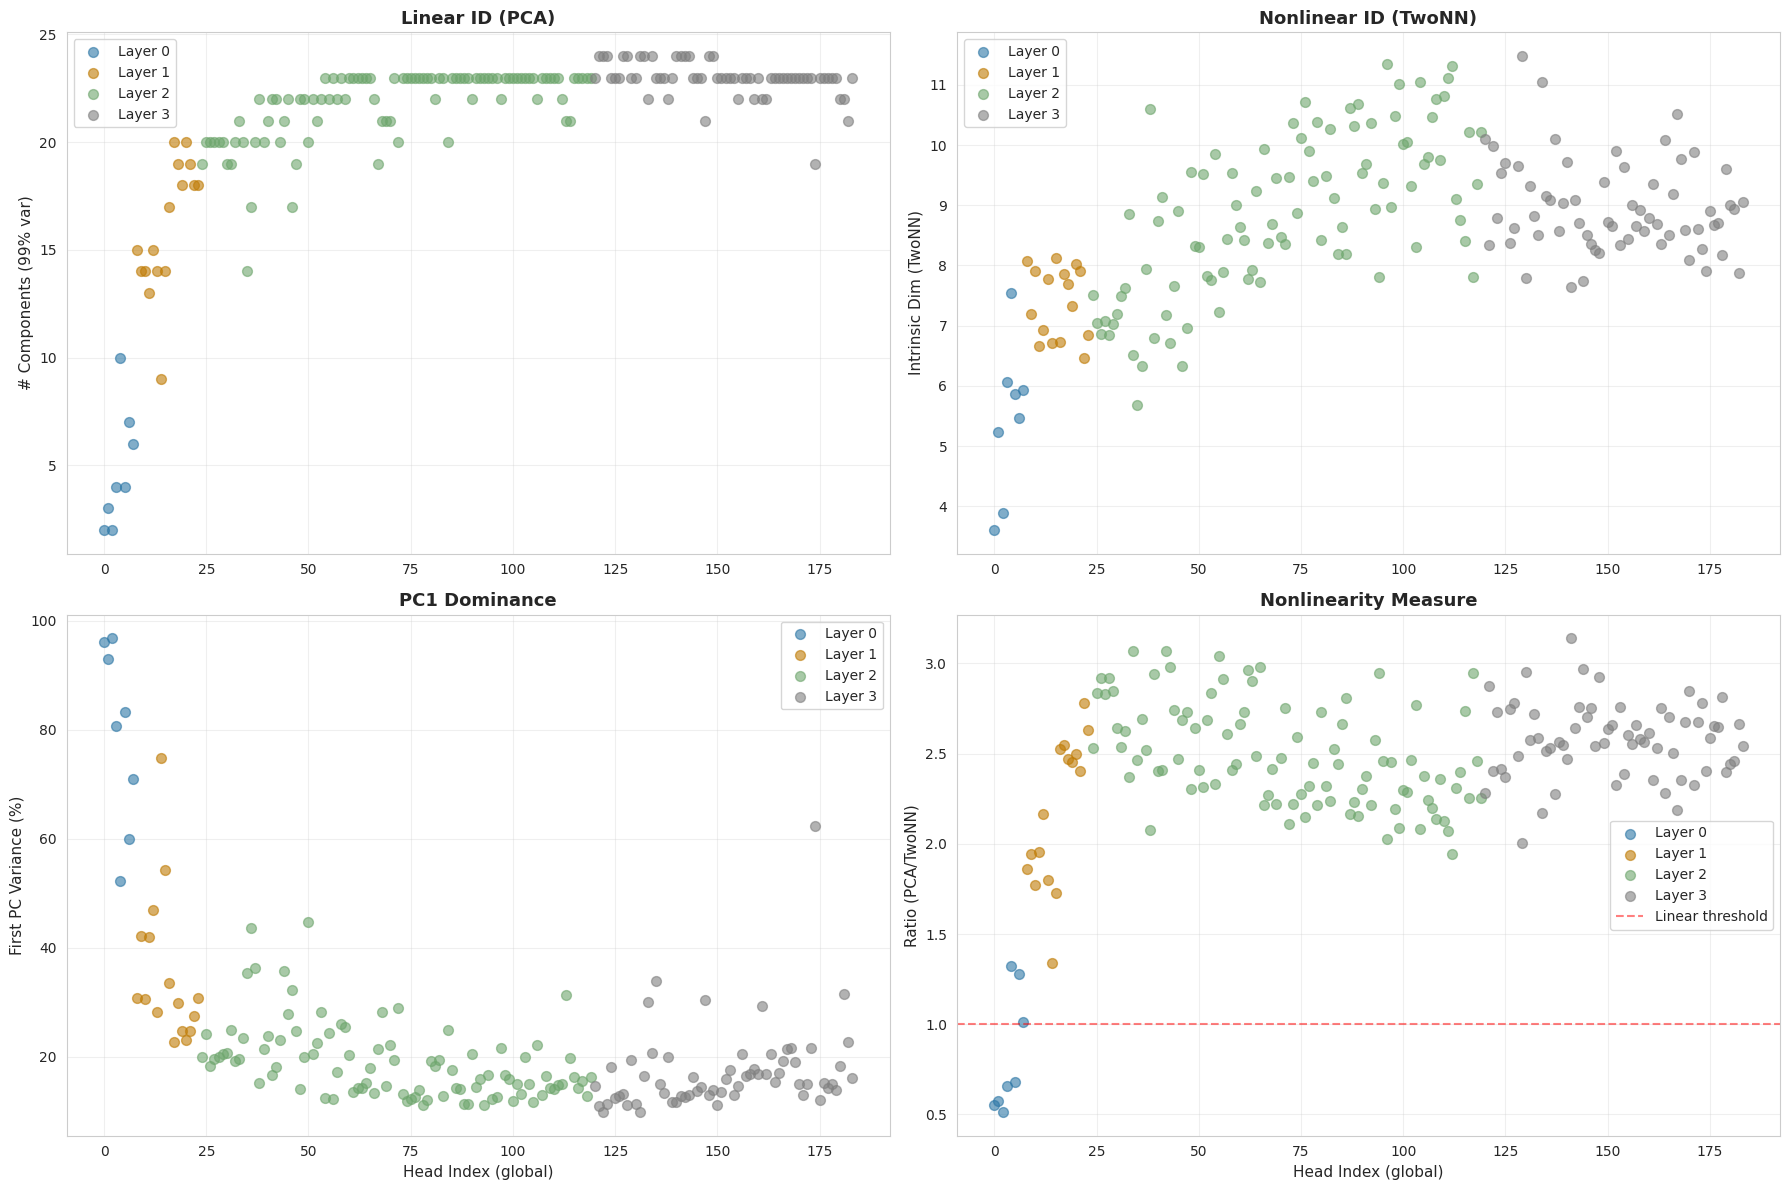

📊 Saved: dimensionality_analysis.png


In [20]:
# ============================================================================
# VISUALIZATION: INTRINSIC DIMENSIONALITY
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

layer_colors = {0: COLORS['blue'], 1: COLORS['orange'], 2: COLORS['green'], 3: COLORS['gray']}

# Merge dataframes
comp_df = pca_df.merge(twonn_df, on='head_id')
comp_df['ratio'] = comp_df['n_comp_99'] / comp_df['twonn_id']
comp_df['global_idx'] = range(len(comp_df))

# Plot 1: PCA Components
ax1 = axes[0, 0]
for layer in range(4):
    layer_data = comp_df[comp_df['layer_x'] == layer]
    ax1.scatter(layer_data['global_idx'], layer_data['n_comp_99'],
               c=layer_colors[layer], label=f'Layer {layer}', alpha=0.6, s=50)
ax1.set_ylabel('# Components (99% var)', fontsize=11)
ax1.set_title('Linear ID (PCA)', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: TwoNN ID
ax2 = axes[0, 1]
for layer in range(4):
    layer_data = comp_df[comp_df['layer_x'] == layer]
    ax2.scatter(layer_data['global_idx'], layer_data['twonn_id'],
               c=layer_colors[layer], label=f'Layer {layer}', alpha=0.6, s=50)
ax2.set_ylabel('Intrinsic Dim (TwoNN)', fontsize=11)
ax2.set_title('Nonlinear ID (TwoNN)', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: First PC Dominance
ax3 = axes[1, 0]
for layer in range(4):
    layer_data = comp_df[comp_df['layer_x'] == layer]
    ax3.scatter(layer_data['global_idx'], layer_data['evr1'] * 100,
               c=layer_colors[layer], label=f'Layer {layer}', alpha=0.6, s=50)
ax3.set_ylabel('First PC Variance (%)', fontsize=11)
ax3.set_xlabel('Head Index (global)', fontsize=11)
ax3.set_title('PC1 Dominance', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Ratio (Nonlinearity)
ax4 = axes[1, 1]
for layer in range(4):
    layer_data = comp_df[comp_df['layer_x'] == layer]
    ax4.scatter(layer_data['global_idx'], layer_data['ratio'],
               c=layer_colors[layer], label=f'Layer {layer}', alpha=0.6, s=50)
ax4.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Linear threshold')
ax4.set_ylabel('Ratio (PCA/TwoNN)', fontsize=11)
ax4.set_xlabel('Head Index (global)', fontsize=11)
ax4.set_title('Nonlinearity Measure', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dimensionality_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Saved: dimensionality_analysis.png")


📐 HTSAT Structure:
   Depths per layer: [2, 2, 6, 2]
   Total blocks: 12

🔍 Aggregation verification:
   Block 0: 4 heads - ['L0_B0_H0', 'L0_B0_H1', 'L0_B0_H2', 'L0_B0_H3']
   Block 1: 4 heads - ['L0_B1_H0', 'L0_B1_H1', 'L0_B1_H2', 'L0_B1_H3']
   Block 2: 8 heads - ['L1_B0_H0', 'L1_B0_H1', 'L1_B0_H2', 'L1_B0_H3', 'L1_B0_H4']

📊 Metrics computed for 12 blocks



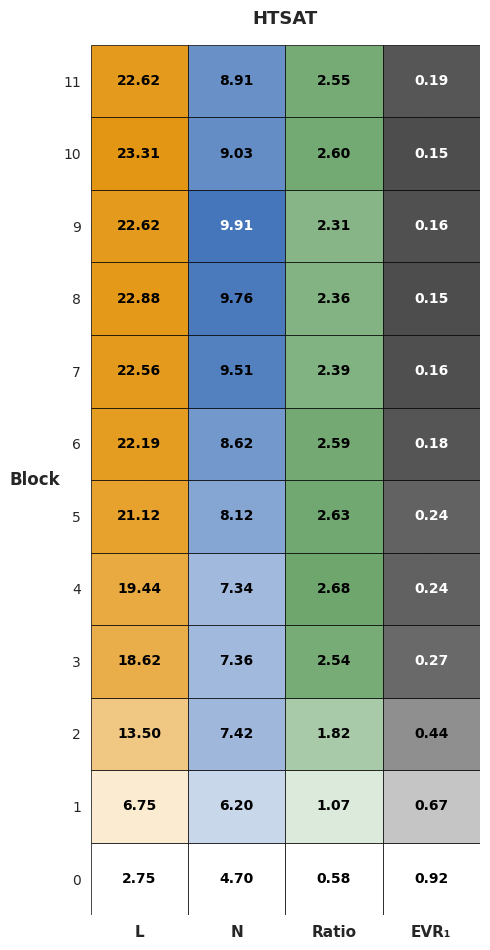

✅ Saved visualization

 Block     L    N  Ratio  EVR1
     0  2.75 4.70   0.58  0.92
     1  6.75 6.20   1.07  0.67
     2 13.50 7.42   1.82  0.44
     3 18.62 7.36   2.54  0.27
     4 19.44 7.34   2.68  0.24
     5 21.12 8.12   2.63  0.24
     6 22.19 8.62   2.59  0.18
     7 22.56 9.51   2.39  0.16
     8 22.88 9.76   2.36  0.15
     9 22.62 9.91   2.31  0.16
    10 23.31 9.03   2.60  0.15
    11 22.62 8.91   2.55  0.19


In [21]:
# ============================================================================
# BLOCK-WISE METRICS VISUALIZATION (COMPACT VERSION - FIXED)
# ============================================================================

# Parse block indices CORRECTLY (from B field, not H field!)
comp_df['block'] = comp_df['head_id'].apply(lambda x: int(x.split('_')[1][1]))  # Extract from B
comp_df['head'] = comp_df['head_id'].apply(lambda x: int(x.split('_')[2][1]))   # Extract from H

def get_global_block(row):
    layer = row['layer_x']
    block = row['block']
    # Sum blocks from all previous layers
    blocks_before = sum(audio_encoder.depths[:layer])
    return blocks_before + block

comp_df['global_block'] = comp_df.apply(get_global_block, axis=1)

# Verify structure
n_blocks = sum(audio_encoder.depths)
print(f"\n📐 HTSAT Structure:")
print(f"   Depths per layer: {audio_encoder.depths}")
print(f"   Total blocks: {n_blocks}")

# Debug: verify aggregation
print("\n🔍 Aggregation verification:")
for b in range(min(3, n_blocks)):
    block_data = comp_df[comp_df['global_block'] == b]
    print(f"   Block {b}: {len(block_data)} heads - {block_data['head_id'].tolist()[:5]}")

# Aggregate metrics per block (all heads in same block together)
metrics_df = pd.DataFrame([{
    'Block': b,
    'L': comp_df[comp_df['global_block'] == b]['n_comp_99'].mean(),
    'N': comp_df[comp_df['global_block'] == b]['twonn_id'].mean(),
    'Ratio': (comp_df[comp_df['global_block'] == b]['n_comp_99'] / 
              comp_df[comp_df['global_block'] == b]['twonn_id']).mean(),
    'EVR1': comp_df[comp_df['global_block'] == b]['evr1'].mean()
} for b in range(n_blocks)])

print(f"\n📊 Metrics computed for {len(metrics_df)} blocks\n")

# Plot
fig, ax = plt.subplots(figsize=(5, n_blocks*0.8))
data = metrics_df[['L', 'N', 'Ratio', 'EVR1']].values

# Color functions with custom palette
orange = lambda v, mn, mx: tuple(1 - (v-mn)/(mx-mn)*(1-c) for c in (0.89, 0.59, 0.08))
blue = lambda v, mn, mx: tuple(1 - (v-mn)/(mx-mn)*(1-c) for c in (0.27, 0.46, 0.73))
green = lambda v, mn, mx: tuple(1 - (v-mn)/(mx-mn)*(1-c) for c in (0.43, 0.65, 0.43))
gray = lambda v, mn, mx: ((g := 0.3 + (v-mn)/(mx-mn)*0.7), g, g)

for i in range(n_blocks):
    for j, (val, cfn) in enumerate(zip(data[i], [orange, blue, green, gray])):
        col_min, col_max = data[:, j].min(), data[:, j].max()
        color = cfn(val, col_min, col_max)
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fc=color, ec='black', lw=0.5))
        ax.text(j+0.5, i+0.5, f"{val:.2f}", ha='center', va='center', 
                fontsize=10, fontweight='bold', 
                color='white' if sum(color)/3 < 0.5 else 'black')

ax.set(xlim=(0,4), ylim=(0,n_blocks), xticks=np.arange(4)+0.5, yticks=np.arange(n_blocks)+0.5)
ax.set_xticklabels(['L', 'N', 'Ratio', 'EVR₁'], fontsize=11, fontweight='bold')
ax.set_yticklabels(range(n_blocks), fontsize=10)
ax.xaxis.tick_bottom()
ax.set_ylabel('Block', fontsize=12, fontweight='bold', rotation=0, labelpad=20, va='center')
ax.set_title('HTSAT', fontsize=13, fontweight='bold', pad=15)
for spine in ax.spines.values(): spine.set_visible(False)
ax.tick_params(left=False, top=False, bottom=False)

plt.tight_layout()
plt.savefig('htsat_block_metrics.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"✅ Saved visualization\n\n{metrics_df.round(2).to_string(index=False)}")

In [22]:
comp_df.head()

,head_id,layer_x,n_comp_99,evr1,layer_y,twonn_id,ratio,global_idx,block,head,global_block
0,L0_B0_H0,0,2,0.960600,0,3.610228,0.553982,0,0,0,0
1,L0_B0_H1,0,3,0.929704,0,5.234348,0.573137,1,0,1,0
2,L0_B0_H2,0,2,0.967602,0,3.893891,0.513625,2,0,2,0
3,L0_B0_H3,0,4,0.806611,0,6.064285,0.659600,3,0,3,0
4,L0_B1_H0,0,10,0.522528,0,7.545759,1.325248,4,1,0,1



📊 Creating PC heatmaps...


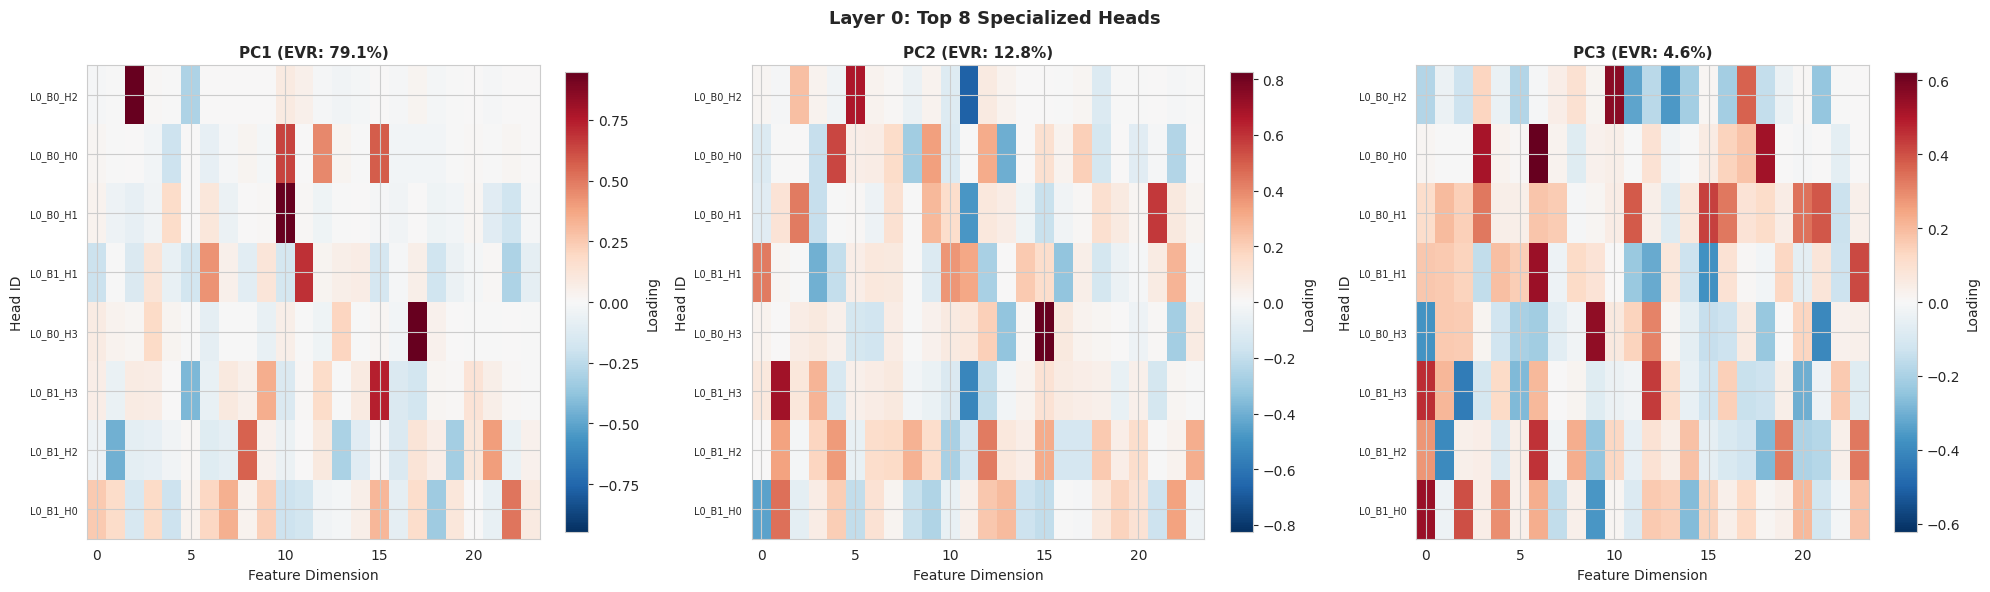

   ✅ Saved: layer0_pc_heatmap.png


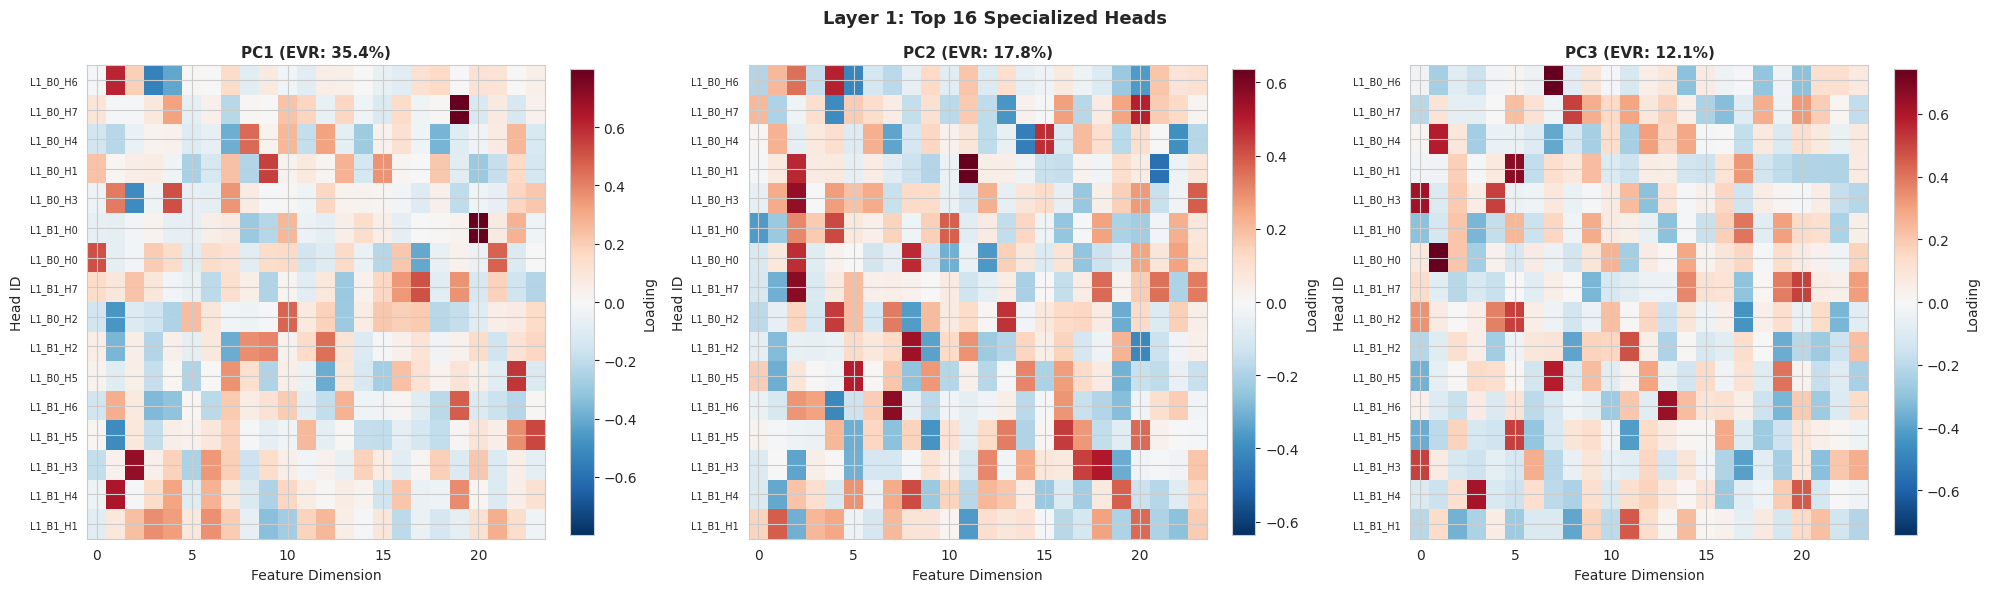

   ✅ Saved: layer1_pc_heatmap.png


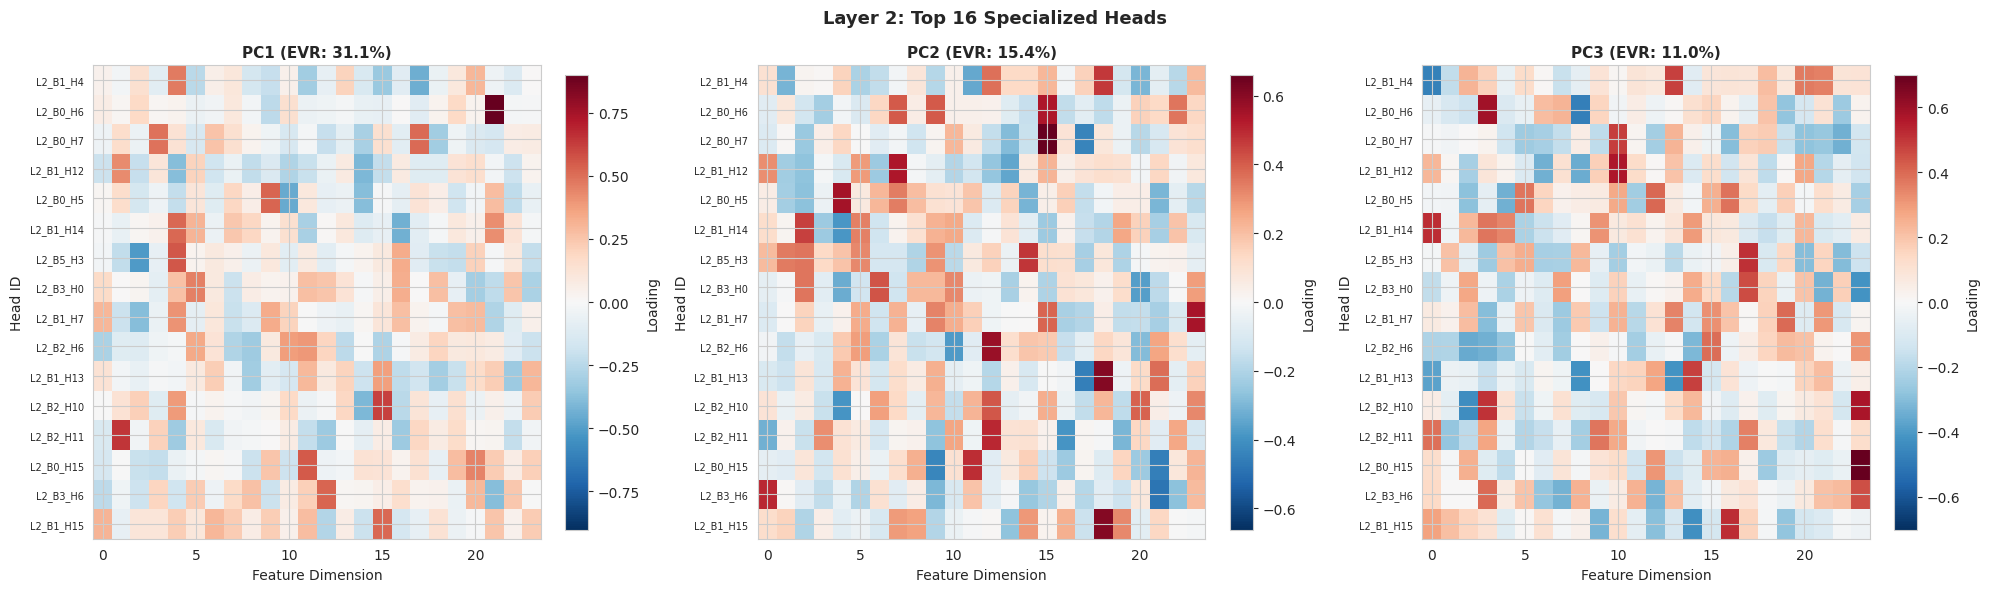

   ✅ Saved: layer2_pc_heatmap.png


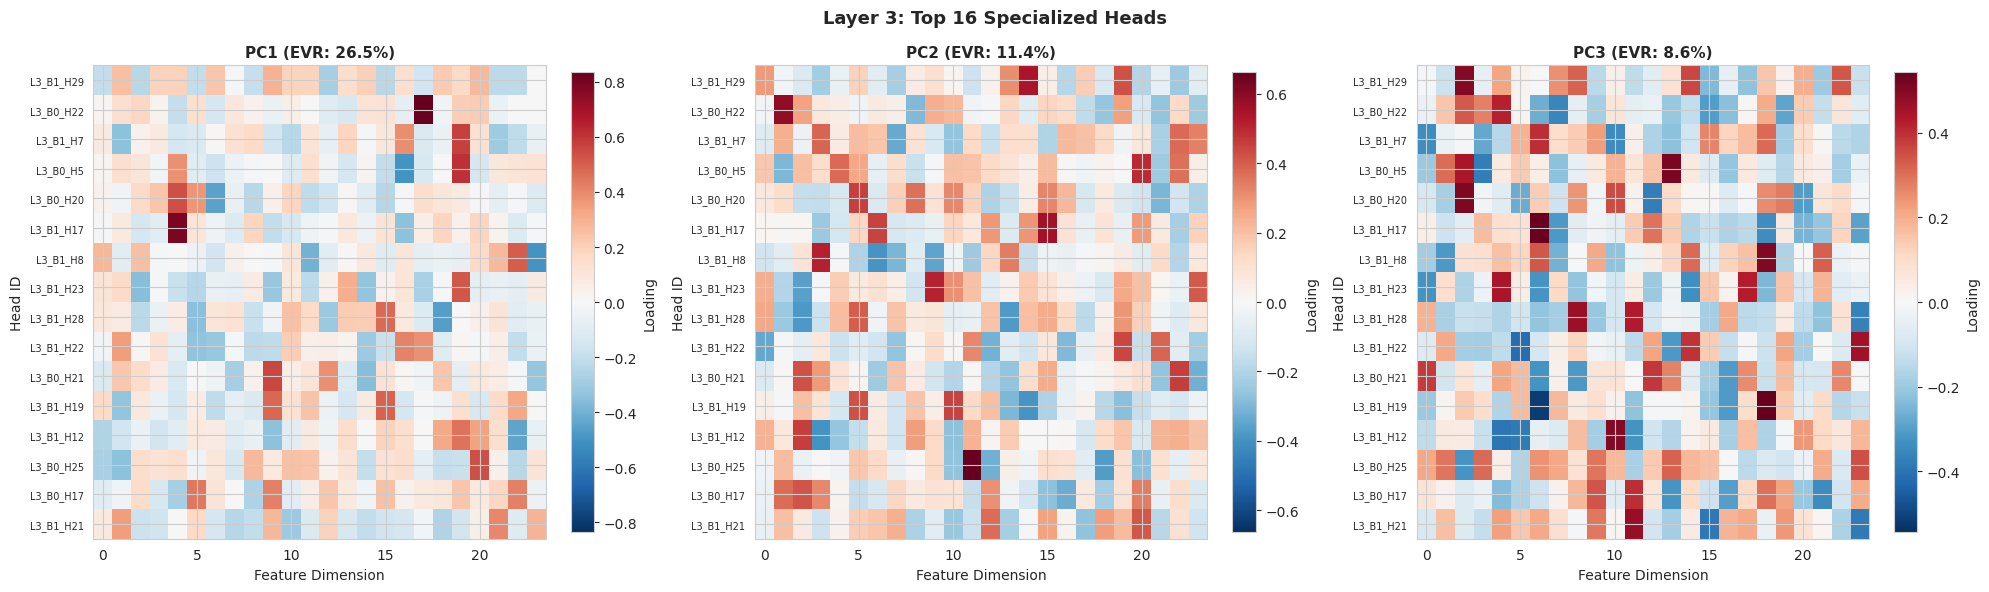

   ✅ Saved: layer3_pc_heatmap.png


In [23]:
# ============================================================================
# VISUALIZATION: PC LOADINGS HEATMAPS
# ============================================================================

def plot_pc_heatmap(layer_idx, top_k=16):
    """Plot PC loadings for top-k most specialized heads"""
    
    # Filter layer heads
    layer_heads = {k: v for k, v in head_pca_results.items() if v['layer'] == layer_idx}
    
    if len(layer_heads) == 0:
        print(f"⚠️  No heads in layer {layer_idx}")
        return
    
    # Sort by EVR1 (specialization)
    sorted_heads = sorted(layer_heads.items(), key=lambda x: x[1]['evr1'], reverse=True)
    top_heads = sorted_heads[:min(top_k, len(sorted_heads))]
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    for pc_idx, ax in enumerate(axes):
        pc_matrix = np.array([h[1]['components'][pc_idx] for h in top_heads])
        
        im = ax.imshow(pc_matrix, aspect='auto', cmap='RdBu_r',
                      vmin=-np.abs(pc_matrix).max(),
                      vmax=np.abs(pc_matrix).max())
        
        ax.set_yticks(range(len(top_heads)))
        ax.set_yticklabels([h[0] for h in top_heads], fontsize=7)
        ax.set_xlabel('Feature Dimension', fontsize=10)
        ax.set_ylabel('Head ID', fontsize=10)
        
        mean_evr = np.mean([h[1]['explained_variance_ratio'][pc_idx] for h in top_heads])
        ax.set_title(f'PC{pc_idx+1} (EVR: {mean_evr:.1%})', fontsize=11, fontweight='bold')
        
        plt.colorbar(im, ax=ax, label='Loading', fraction=0.046)
    
    plt.suptitle(f'Layer {layer_idx}: Top {len(top_heads)} Specialized Heads',
                fontsize=13, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig(f'layer{layer_idx}_pc_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"   ✅ Saved: layer{layer_idx}_pc_heatmap.png")

print("\n📊 Creating PC heatmaps...")
for layer in range(4):
    plot_pc_heatmap(layer, top_k=16)


COMPUTING DISCRIMINATIVE POWER


Discrimination:   0%|          | 0/184 [00:00<?, ?it/s]

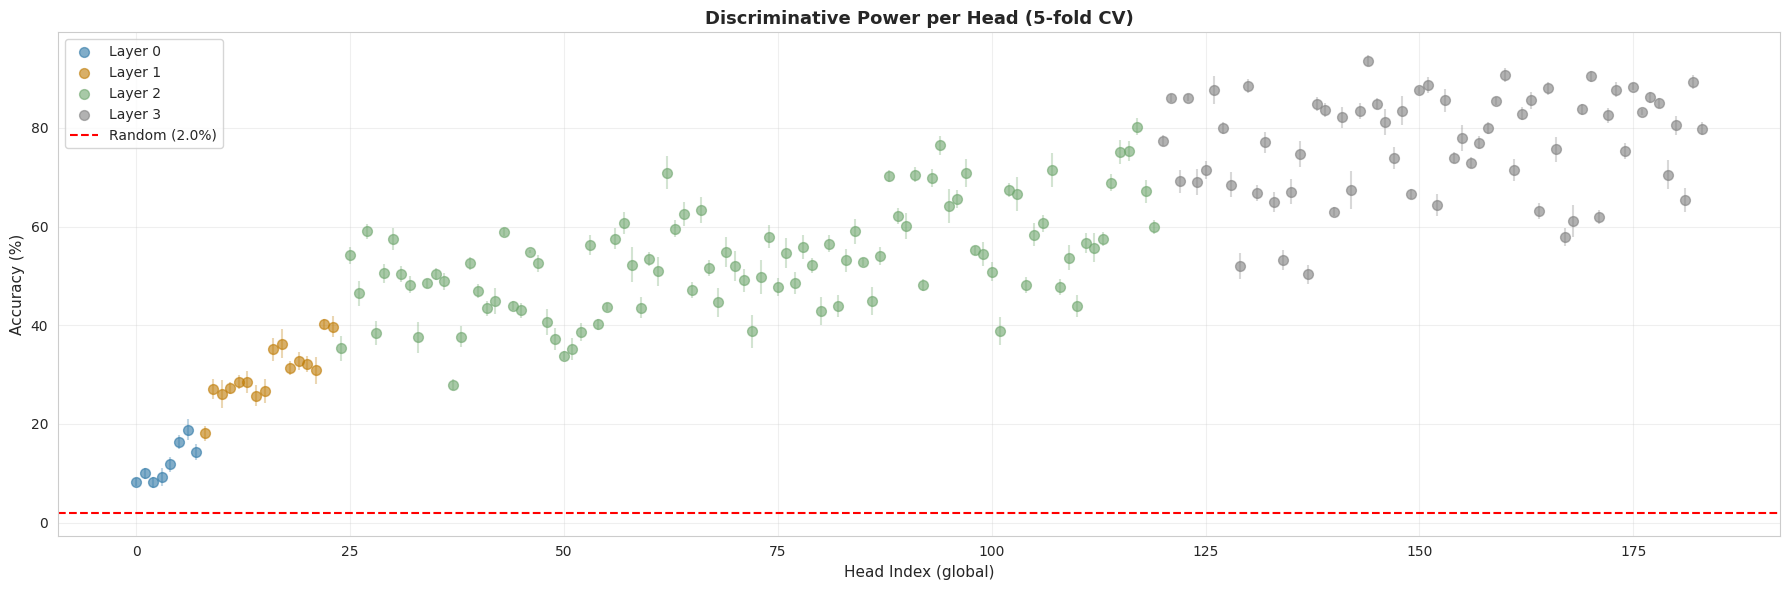

📊 Saved: discriminative_power.png

🏆 Top 10 Most Discriminative Heads:
 1. L3_B0_H30: 93.60% (±1.11%)
 2. L3_B1_H16: 90.75% (±1.42%)
 3. L3_B1_H25: 90.45% (±1.07%)
 4. L3_B1_H8: 89.25% (±1.41%)
 5. L3_B0_H9: 88.70% (±1.61%)
 6. L3_B0_H18: 88.50% (±1.41%)
 7. L3_B1_H3: 88.35% (±0.72%)
 8. L3_B1_H20: 88.05% (±1.30%)
 9. L3_B1_H28: 87.75% (±1.49%)
10. L3_B0_H8: 87.60% (±0.77%)


In [29]:
# ============================================================================
# DISCRIMINATIVE POWER ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("COMPUTING DISCRIMINATIVE POWER")
print("="*70)

head_discrimination = {}

for head_id, head_repr in tqdm(head_outputs_final.items(), desc="Discrimination"):
    X = head_repr.numpy()
    y = sample_labels
    
    clf = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy', n_jobs=-1)
    
    head_discrimination[head_id] = {
        'mean_acc': scores.mean(),
        'std_acc': scores.std(),
        'layer': int(head_id.split('_')[0][1])
    }

# Plot
fig, ax = plt.subplots(figsize=(18, 6))

disc_df = pd.DataFrame([
    {'head_id': hid, 'layer': res['layer'], 'mean_acc': res['mean_acc'], 'std_acc': res['std_acc']}
    for hid, res in head_discrimination.items()
])
disc_df['global_idx'] = range(len(disc_df))

for layer in range(4):
    layer_data = disc_df[disc_df['layer'] == layer]
    ax.scatter(layer_data['global_idx'], layer_data['mean_acc'] * 100,
              c=layer_colors[layer], label=f'Layer {layer}', alpha=0.6, s=50)
    ax.errorbar(layer_data['global_idx'], layer_data['mean_acc'] * 100,
               yerr=layer_data['std_acc'] * 100,
               fmt='none', c=layer_colors[layer], alpha=0.3)

ax.axhline(y=100/len(dataset.classes), color='red', linestyle='--',
          label=f'Random ({100/len(dataset.classes):.1f}%)')
ax.set_xlabel('Head Index (global)', fontsize=11)
ax.set_ylabel('Accuracy (%)', fontsize=11)
ax.set_title('Discriminative Power per Head (5-fold CV)', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('discriminative_power.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Saved: discriminative_power.png")

# Top heads
print("\n🏆 Top 10 Most Discriminative Heads:")
top_disc = disc_df.nlargest(10, 'mean_acc')
for idx, row in enumerate(top_disc.itertuples(), 1):
    print(f"{idx:2d}. {row.head_id}: {row.mean_acc*100:.2f}% (±{row.std_acc*100:.2f}%)")


HEAD SIMILARITY ANALYSIS

🔹 Computing t-SNE...


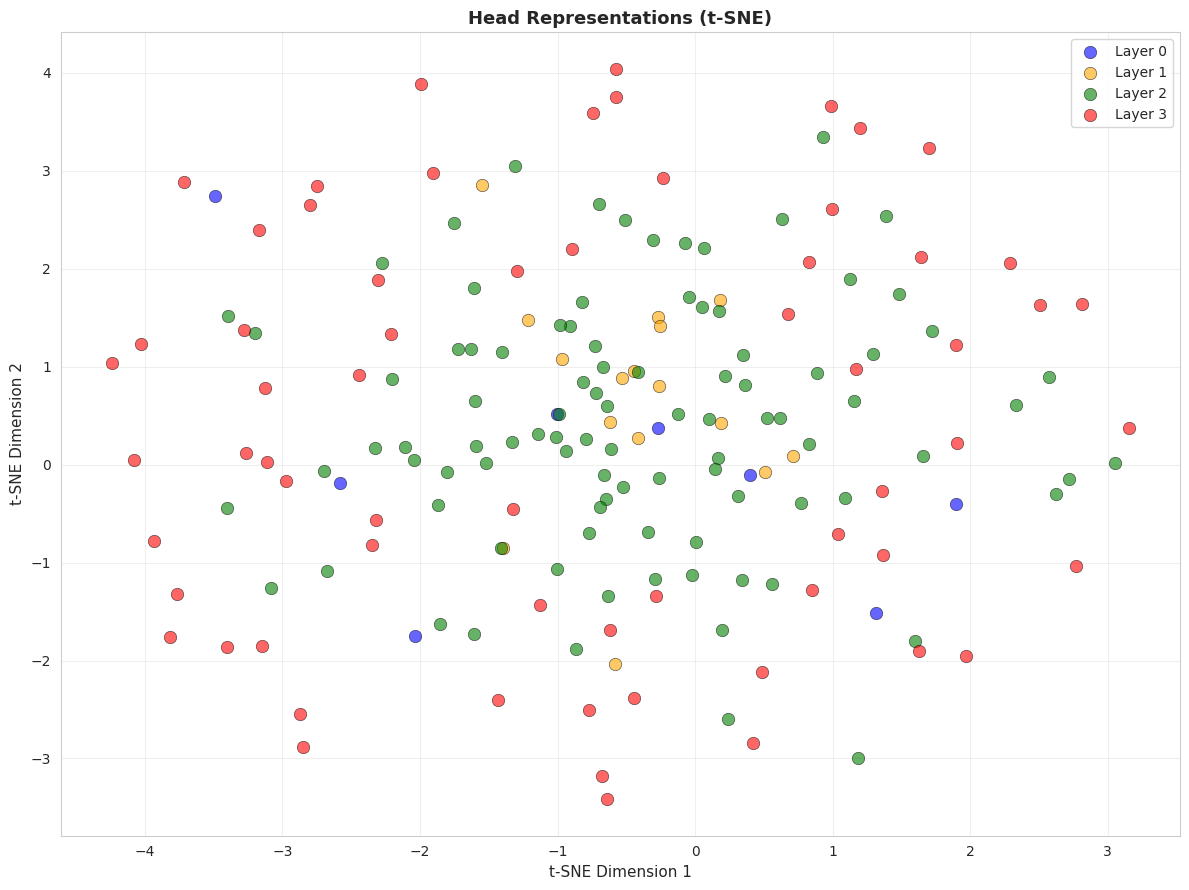

   ✅ Saved: head_tsne.png

🔹 Computing correlation matrices...


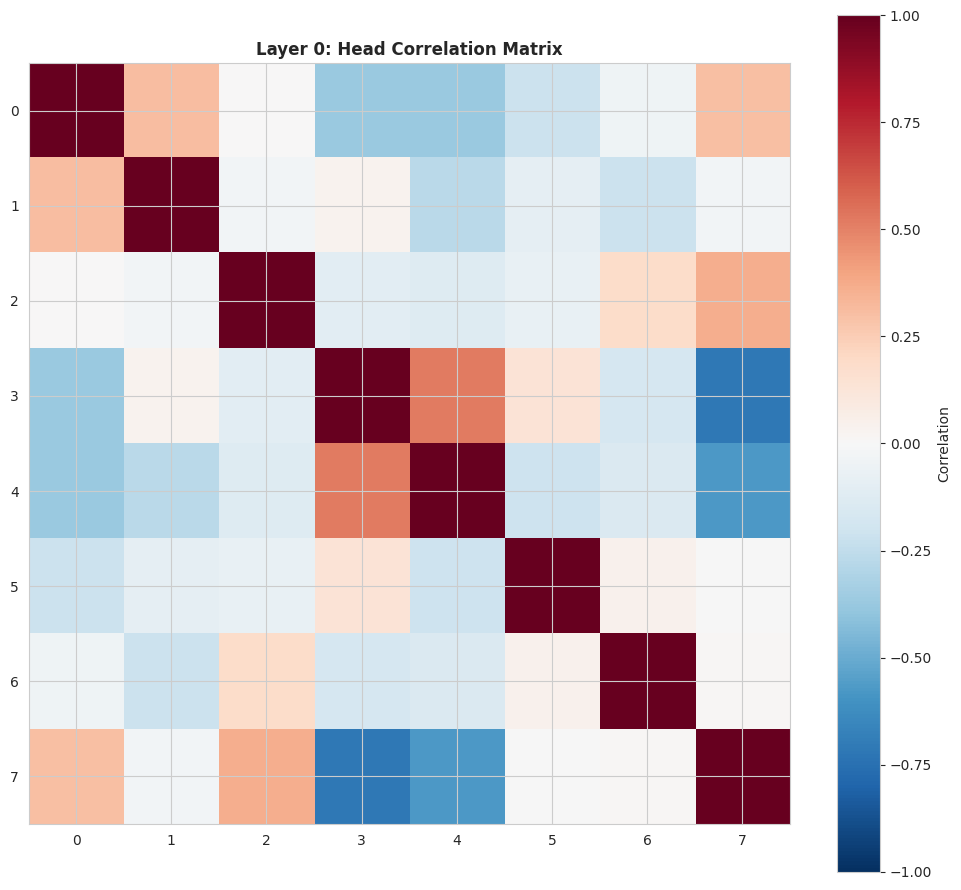

   ✅ Saved: layer0_correlation.png


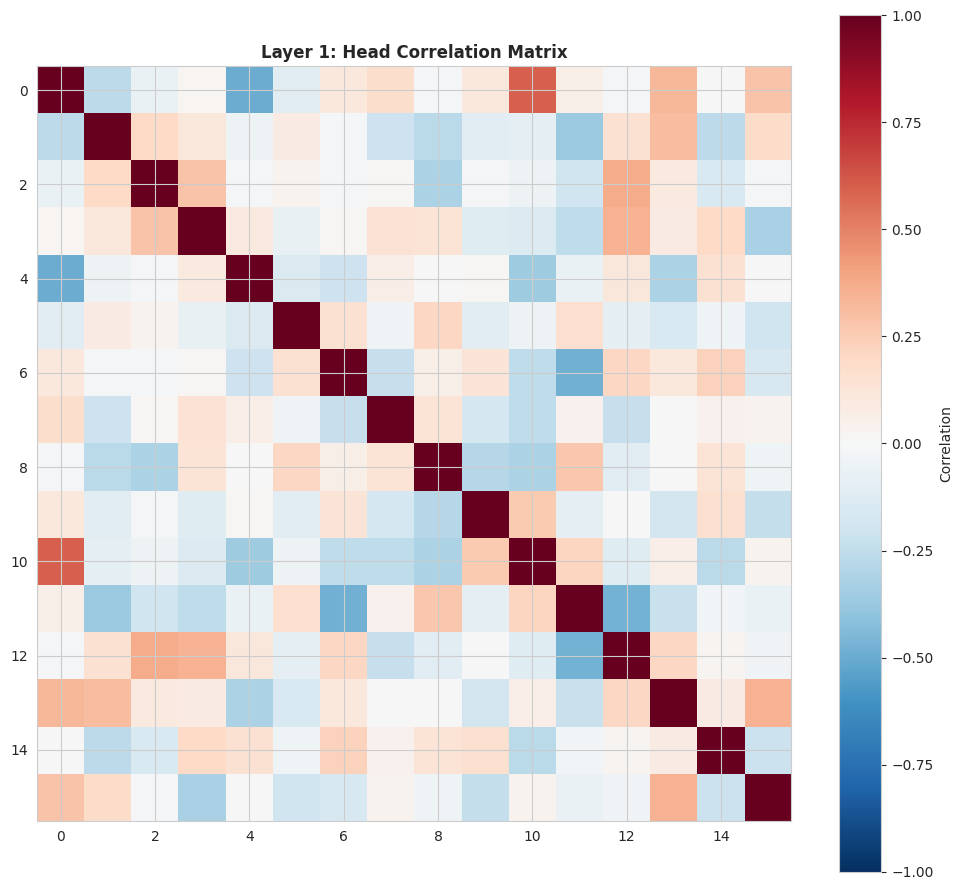

   ✅ Saved: layer1_correlation.png


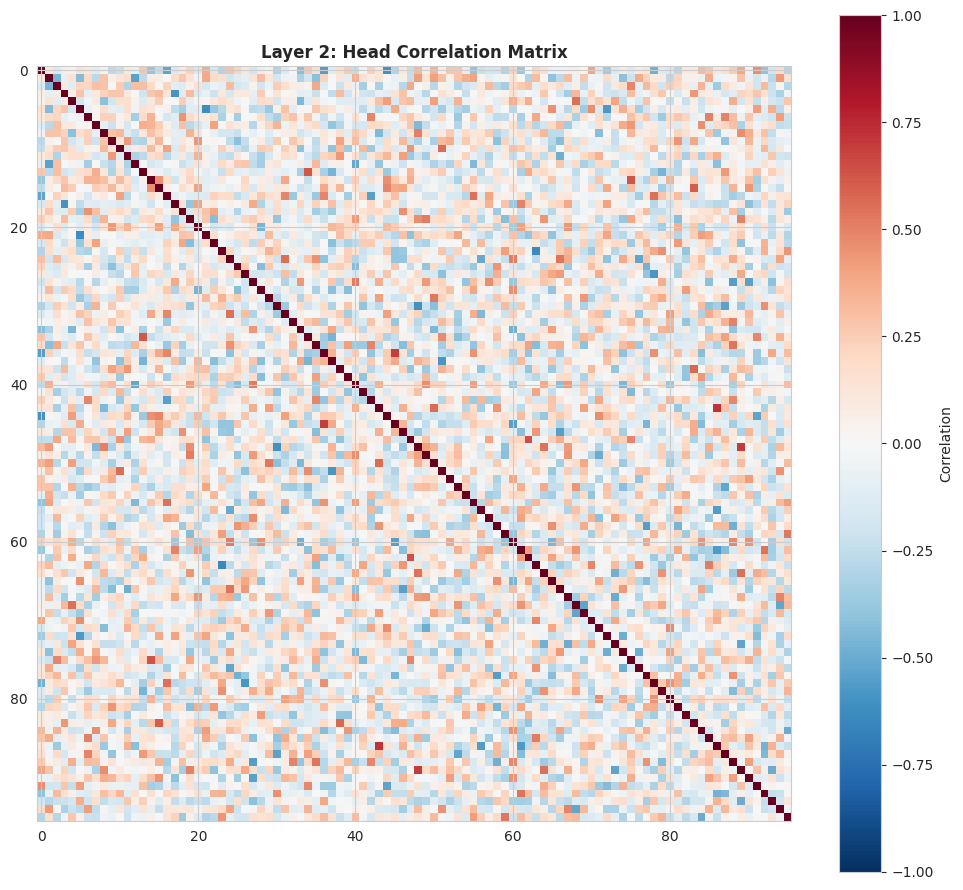

   ✅ Saved: layer2_correlation.png


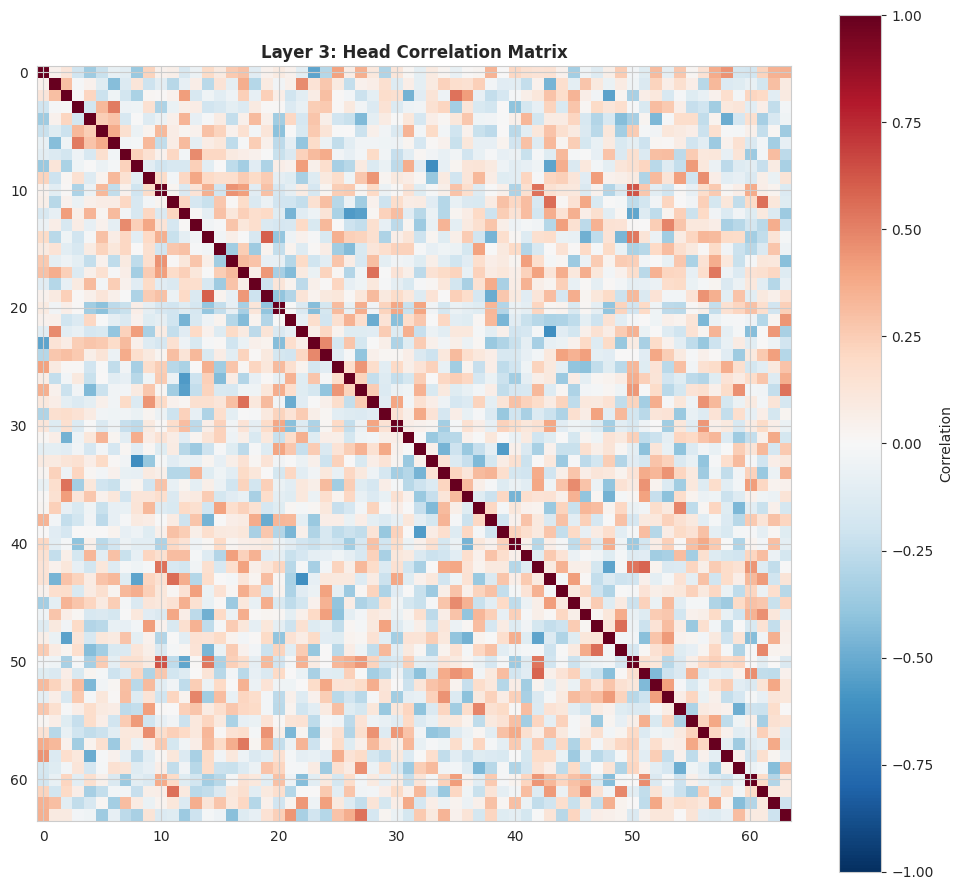

   ✅ Saved: layer3_correlation.png


In [ ]:
# ============================================================================
# HEAD SIMILARITY ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("HEAD SIMILARITY ANALYSIS")
print("="*70)

# t-SNE embedding
print("\n🔹 Computing t-SNE...")
head_means = np.array([v.mean(dim=0).numpy() for v in head_outputs_final.values()])
head_ids = list(head_outputs_final.keys())
head_layers = [int(hid.split('_')[0][1]) for hid in head_ids]

tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(head_means)-1))
heads_2d = tsne.fit_transform(head_means)

# Plot t-SNE
fig, ax = plt.subplots(figsize=(12, 9))

for layer in range(4):
    mask = np.array(head_layers) == layer
    ax.scatter(heads_2d[mask, 0], heads_2d[mask, 1],
              c=layer_colors[layer], label=f'Layer {layer}',
              alpha=0.6, s=80, edgecolors='black', linewidth=0.5)

ax.set_xlabel('t-SNE Dimension 1', fontsize=11)
ax.set_ylabel('t-SNE Dimension 2', fontsize=11)
ax.set_title('Head Representations (t-SNE)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('head_tsne.png', dpi=300, bbox_inches='tight')
plt.show()

print("   ✅ Saved: head_tsne.png")

# Correlation matrices per layer
print("\n🔹 Computing correlation matrices...")

for layer in range(4):
    layer_heads = {k: v for k, v in head_outputs_final.items()
                  if int(k.split('_')[0][1]) == layer}
    
    if len(layer_heads) < 2:
        continue
    
    head_means_layer = np.array([v.mean(dim=0).numpy() for v in layer_heads.values()])
    corr_matrix = np.corrcoef(head_means_layer)
    
    fig, ax = plt.subplots(figsize=(10, 9))
    
    im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
    
    ax.set_title(f'Layer {layer}: Head Correlation Matrix',
                fontsize=12, fontweight='bold')
    
    plt.colorbar(im, ax=ax, label='Correlation')
    plt.tight_layout()
    plt.savefig(f'layer{layer}_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"   ✅ Saved: layer{layer}_correlation.png")

In [32]:
# ============================================================================
# SUMMARY & EXPORT
# ============================================================================

print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

# Merge all results
summary_df = comp_df.copy()
summary_df = summary_df.merge(disc_df[['head_id', 'mean_acc', 'std_acc']], on='head_id')

# Summary statistics per layer
summary_stats = summary_df.groupby('layer_x').agg({
    'n_comp_99': ['mean', 'std'],
    'twonn_id': ['mean', 'std'],
    'evr1': ['mean', 'std'],
    'ratio': ['mean', 'std'],
    'mean_acc': ['mean', 'max']
}).round(3)

summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns]
summary_stats = summary_stats.rename(columns=lambda x: x.replace('_x', ''))

print("\n📊 Summary by Layer:")
print(summary_stats)

# Save
summary_df.to_csv('head_analysis_complete.csv', index=False)
summary_stats.to_csv('head_analysis_summary.csv')

print("\n💾 Saved:")
print("   - head_analysis_complete.csv (all heads)")
print("   - head_analysis_summary.csv (per-layer stats)")

print("\n" + "="*70)
print("✅ ANALYSIS COMPLETE!")
print("="*70)
print(f"\n📁 Generated files:")
print(f"   - dimensionality_analysis.png")
print(f"   - layer[0-3]_pc_heatmap.png (4 files)")
print(f"   - discriminative_power.png")
print(f"   - head_tsne.png")
print(f"   - layer[0-3]_correlation.png (4 files)")
print(f"   - head_analysis_complete.csv")
print(f"   - head_analysis_summary.csv")
print(f"\n🎯 Total: 13 files generated")


FINAL SUMMARY

📊 Summary by Layer:
         n_comp_99_mean  n_comp_99_std  twonn_id_mean  twonn_id_std  \
layer_x                                                               
0                 4.750          2.765          5.452         1.255   
1                16.062          3.043          7.390         0.589   
2                21.802          1.671          8.877         1.332   
3                22.969          0.854          8.969         0.772   

         evr1_mean  evr1_std  ratio_mean  ratio_std  mean_acc_mean  \
layer_x                                                              
0            0.791     0.168       0.825      0.332          0.121   
1            0.354     0.139       2.179      0.413          0.304   
2            0.190     0.069       2.492      0.283          0.533   
3            0.173     0.078       2.576      0.208          0.768   

         mean_acc_max  
layer_x                
0               0.188  
1               0.402  
2               0.80

In [ ]:
# ============================================================================
# ADVANCED HEAD INTERPRETATION
# ============================================================================

print("\n" + "="*70)
print("ADVANCED INTERPRETATION ANALYSIS")
print("="*70)

In [26]:
# ============================================================================
# 1. DATASET EXEMPLARS - Find samples that maximally activate each head
# ============================================================================

print("\n🔍 1/3: Computing Dataset Exemplars...")

head_exemplars = {}

# Load labels
sample_labels = loaded['labels']

for head_id, head_repr in tqdm(head_outputs_final.items(), desc="Exemplars"):
    # Compute activation magnitude per sample
    activations = head_repr.norm(dim=1).numpy()
    
    # Get top-k and bottom-k
    top_k = 5
    top_indices = np.argsort(activations)[-top_k:][::-1]
    bottom_indices = np.argsort(activations)[:top_k]
    
    head_exemplars[head_id] = {
        'top_activations': activations[top_indices],
        'top_classes': sample_labels[top_indices],
        'bottom_activations': activations[bottom_indices],
        'bottom_classes': sample_labels[bottom_indices]
    }

# Analyze specialization
print("\n📊 Most Specialized Heads (by class concentration):")
for head_id, exemplar in list(head_exemplars.items())[:10]:
    top_classes = exemplar['top_classes']
    unique, counts = np.unique(top_classes, return_counts=True)
    dominant_class = unique[np.argmax(counts)]
    concentration = counts.max() / len(top_classes)
    
    if concentration >= 0.6:  # 60%+ same class
        print(f"  {head_id}: {concentration*100:.0f}% → Class {dominant_class} ({dataset.classes[dominant_class]})")



🔍 1/3: Computing Dataset Exemplars...


Exemplars:   0%|          | 0/184 [00:00<?, ?it/s]


📊 Most Specialized Heads (by class concentration):
  L0_B0_H2: 60% → Class 46 (vacuum cleaner)
  L0_B1_H1: 80% → Class 46 (vacuum cleaner)
  L0_B1_H2: 60% → Class 46 (vacuum cleaner)
  L1_B0_H1: 100% → Class 10 (clock alarm)


In [27]:
# ============================================================================
# 2. CLASS-SPECIFIC PROBING - Which heads encode which audio properties
# ============================================================================

print("\n🔍 2/3: Class-Specific Probing...")

# Define semantic groupings (adapt to ESC-50)
audio_categories = {
    'Animals': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],  # dog, rooster, pig, cow, frog, cat, hen, insects, sheep, crow
    'Natural': [20, 21, 22, 23, 24],  # rain, sea_waves, crackling_fire, crickets, chirping_birds
    'Human': [25, 26, 27, 28, 29],  # breathing, coughing, sneezing, footsteps, laughing
    'Interior': [30, 31, 32, 33, 34],  # door_wood_knock, mouse_click, keyboard_typing, door_wood_creaks, can_opening
    'Exterior': [35, 36, 37, 38, 39],  # washing_machine, vacuum_cleaner, clock_alarm, clock_tick, glass_breaking
    'Urban': [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]  # helicopter, chainsaw, siren, car_horn, engine, train, church_bells, airplane, fireworks, hand_saw
}

category_probing = defaultdict(dict)

for head_id, head_repr in tqdm(list(head_outputs_final.items())[:50], desc="Category Probe"):  # Sample first 50 heads
    X = head_repr.numpy()
    
    for cat_name, class_indices in audio_categories.items():
        # Binary classification: this category vs rest
        y_binary = np.isin(sample_labels, class_indices).astype(int)
        
        if len(np.unique(y_binary)) < 2:  # Skip if only one class
            continue
            
        clf = LogisticRegression(max_iter=500, random_state=42)
        scores = cross_val_score(clf, X, y_binary, cv=3, scoring='accuracy')
        
        category_probing[head_id][cat_name] = scores.mean()

# Find specialized heads per category
print("\n📊 Category-Specialized Heads:")
for cat_name in audio_categories.keys():
    cat_scores = [(hid, scores[cat_name]) for hid, scores in category_probing.items() if cat_name in scores]
    cat_scores.sort(key=lambda x: x[1], reverse=True)
    
    if cat_scores:
        top_head, top_score = cat_scores[0]
        print(f"  {cat_name:12s}: {top_head} (acc: {top_score*100:.1f}%)")



🔍 2/3: Class-Specific Probing...


Category Probe:   0%|          | 0/50 [00:00<?, ?it/s]


📊 Category-Specialized Heads:
  Animals     : L2_B0_H12 (acc: 63.4%)
  Natural     : L2_B1_H11 (acc: 90.4%)
  Human       : L1_B1_H7 (acc: 90.1%)
  Interior    : L2_B0_H2 (acc: 90.4%)
  Exterior    : L2_B1_H14 (acc: 90.2%)
  Urban       : L2_B1_H3 (acc: 80.0%)


In [30]:
# ============================================================================
# 3. SPARSE CODING WITH CLASS PROTOTYPES
# ============================================================================

print("\n🔍 3/3: Sparse Coding with Class Prototypes...")

# Compute class prototypes (dictionary)
class_prototypes = {}
for class_idx in range(len(dataset.classes)):
    class_mask = sample_labels == class_idx
    if class_mask.sum() > 0:
        # Average across all heads for this class
        prototype = []
        for head_repr in head_outputs_final.values():
            prototype.append(head_repr[class_mask].mean(dim=0))
        class_prototypes[class_idx] = torch.stack(prototype).mean(dim=0).numpy()

# Dictionary matrix: [n_classes, head_dim]
D = np.array([class_prototypes[i] for i in sorted(class_prototypes.keys())])

# Analyze 5 most discriminative heads with SOMP-like approach
top_disc_heads = disc_df.nlargest(5, 'mean_acc')['head_id'].tolist()

print("\n📊 Sparse Decomposition (Top 5 Discriminative Heads):")
for head_id in top_disc_heads:
    X = head_outputs_final[head_id].numpy()
    
    # Simple sparse coding: find top-3 most correlated classes per sample
    correlations = X @ D.T  # [n_samples, n_classes]
    
    # Average top-3 classes across samples
    top_k_per_sample = 3
    top_classes_all = []
    for i in range(len(X)):
        top_k_idx = np.argsort(correlations[i])[-top_k_per_sample:]
        top_classes_all.extend(top_k_idx)
    
    # Most frequent classes
    unique, counts = np.unique(top_classes_all, return_counts=True)
    top_3_classes = unique[np.argsort(counts)[-3:][::-1]]
    
    print(f"\n  {head_id}:")
    print(f"    Primarily responds to: {[dataset.classes[i] for i in top_3_classes]}")



🔍 3/3: Sparse Coding with Class Prototypes...

📊 Sparse Decomposition (Top 5 Discriminative Heads):

  L3_B0_H30:
    Primarily responds to: ['water drops', 'thunderstorm', 'clapping']

  L3_B1_H16:
    Primarily responds to: ['insects', 'sneezing', 'door wood knock']

  L3_B1_H25:
    Primarily responds to: ['rain', 'brushing teeth', 'pouring water']

  L3_B1_H8:
    Primarily responds to: ['church bells', 'frog', 'brushing teeth']

  L3_B0_H9:
    Primarily responds to: ['insects', 'church bells', 'clapping']



📊 Creating improved interpretation summary plot...


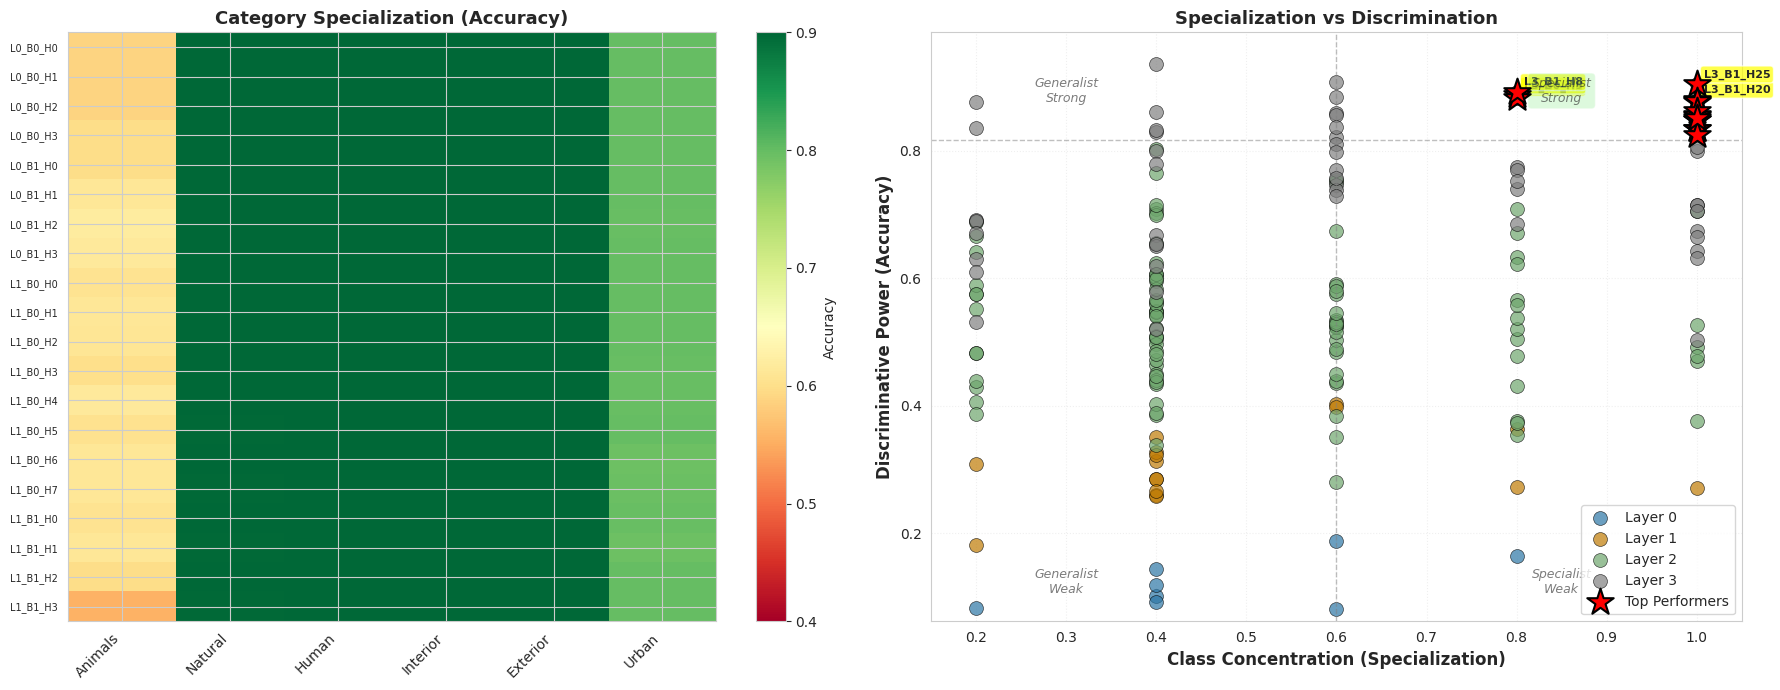

✅ Saved: head_interpretation_summary.png

🎯 Key Insights:
   Specialists (>60% concentration): 55/184
   Top performers (high disc. + spec.): 16

   Top 5 Specialist+Discriminative Heads:
      L3_B1_H20: Spec=1.00, Acc=88.05%
      L3_B1_H3: Spec=0.80, Acc=88.35%
      L3_B0_H9: Spec=0.80, Acc=88.70%
      L3_B1_H8: Spec=0.80, Acc=89.25%
      L3_B1_H25: Spec=1.00, Acc=90.45%


In [34]:
# ============================================================================
# VISUALIZATION: INTERPRETATION SUMMARY (IMPROVED)
# ============================================================================

print("\n📊 Creating improved interpretation summary plot...")

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Category specialization heatmap (unchanged, is good)
ax1 = axes[0]
if category_probing:
    heads_sample = list(category_probing.keys())[:20]
    categories = list(audio_categories.keys())
    
    matrix = np.array([[category_probing[h].get(c, 0.5) for c in categories] 
                       for h in heads_sample])
    
    im1 = ax1.imshow(matrix, cmap='RdYlGn', vmin=0.4, vmax=0.9, aspect='auto')
    ax1.set_yticks(range(len(heads_sample)))
    ax1.set_yticklabels(heads_sample, fontsize=7)
    ax1.set_xticks(range(len(categories)))
    ax1.set_xticklabels(categories, rotation=45, ha='right')
    ax1.set_title('Category Specialization (Accuracy)', fontweight='bold', fontsize=13)
    plt.colorbar(im1, ax=ax1, label='Accuracy')

# Plot 2: IMPROVED Specialization vs Discrimination
ax2 = axes[1]

spec_scores = []
disc_scores = []
layer_ids = []
head_names = []

for head_id in summary_df['head_id']:
    if head_id in head_exemplars and head_id in head_discrimination:
        top_classes = head_exemplars[head_id]['top_classes']
        unique, counts = np.unique(top_classes, return_counts=True)
        concentration = counts.max() / len(top_classes)
        
        spec_scores.append(concentration)
        disc_scores.append(head_discrimination[head_id]['mean_acc'])
        layer_ids.append(int(head_id.split('_')[0][1]))
        head_names.append(head_id)

# Convert to arrays
spec_scores = np.array(spec_scores)
disc_scores = np.array(disc_scores)
layer_ids = np.array(layer_ids)

# Plot per layer with larger markers and alpha
for layer in range(4):
    mask = layer_ids == layer
    ax2.scatter(spec_scores[mask], disc_scores[mask],
               c=layer_colors[layer], label=f'Layer {layer}', 
               alpha=0.7, s=100, edgecolors='black', linewidth=0.5)

# Highlight top performers (high discrimination AND high specialization)
threshold_disc = np.percentile(disc_scores, 85)
threshold_spec = 0.6

top_performers = (disc_scores > threshold_disc) & (spec_scores > threshold_spec)
if top_performers.sum() > 0:
    ax2.scatter(spec_scores[top_performers], disc_scores[top_performers],
               marker='*', s=400, c='red', edgecolors='black', 
               linewidth=1.5, label='Top Performers', zorder=10)
    
    # Annotate top 5
    top_indices = np.where(top_performers)[0]
    top_5_idx = top_indices[np.argsort(disc_scores[top_indices])[-5:]]
    
    for idx in top_5_idx:
        ax2.annotate(head_names[idx], 
                    (spec_scores[idx], disc_scores[idx]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# Add quadrant lines
ax2.axvline(x=0.6, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax2.axhline(y=threshold_disc, color='gray', linestyle='--', alpha=0.5, linewidth=1)

# Labels and styling
ax2.set_xlabel('Class Concentration (Specialization)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Discriminative Power (Accuracy)', fontsize=12, fontweight='bold')
ax2.set_title('Specialization vs Discrimination', fontweight='bold', fontsize=13)
ax2.set_xlim([0.15, 1.05])
ax2.set_ylim([disc_scores.min() - 0.02, disc_scores.max() + 0.05])
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3, linestyle=':')

# Add quadrant labels
ax2.text(0.3, disc_scores.max() - 0.02, 'Generalist\nStrong', 
         ha='center', va='top', fontsize=9, style='italic', alpha=0.6)
ax2.text(0.85, disc_scores.max() - 0.02, 'Specialist\nStrong', 
         ha='center', va='top', fontsize=9, style='italic', alpha=0.6,
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
ax2.text(0.3, disc_scores.min() + 0.02, 'Generalist\nWeak', 
         ha='center', va='bottom', fontsize=9, style='italic', alpha=0.6)
ax2.text(0.85, disc_scores.min() + 0.02, 'Specialist\nWeak', 
         ha='center', va='bottom', fontsize=9, style='italic', alpha=0.6)

plt.tight_layout()
plt.savefig('head_interpretation_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: head_interpretation_summary.png")

# Print insights
print("\n🎯 Key Insights:")
print(f"   Specialists (>60% concentration): {(spec_scores > 0.6).sum()}/{len(spec_scores)}")
print(f"   Top performers (high disc. + spec.): {top_performers.sum()}")
print(f"\n   Top 5 Specialist+Discriminative Heads:")
for idx in top_5_idx:
    print(f"      {head_names[idx]}: Spec={spec_scores[idx]:.2f}, Acc={disc_scores[idx]:.2%}")